In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [6]:
df = pd.read_csv("data/wavelet_features_holter.csv")
y = df["died"].values
X = df.drop(["ID", "died"], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
X.shape

(176, 42)

## Utils


In [7]:
from importlib import reload
import utils

reload(utils)

from utils import (
    preprocess,
    find_best_fold,
    calculate_metrics,
    plot_confusion_matrix,
    display_kfold_scores,
    apply_grid_search,
    extract_params_and_k,
    get_kfold_results,
)

from geometric_mean_score import gmean_scorer
from corr_feature_reducer import CorrelationFeatureReducer
from sklearn.decomposition import PCA

## Constantes


In [8]:
MODEL_PREFIX = "clf"
K_KEY = "select__k"
REDUCTION_TYPE = "kbest"

SELECTOR_MAP = {
    "kbest": SelectKBest(f_classif),
    "corr": CorrelationFeatureReducer(),
    "pca": PCA(),
}

SELECTOR = SELECTOR_MAP[REDUCTION_TYPE]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Logistic Regression


In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("select", SELECTOR),
        ("clf", LogisticRegression(solver="liblinear", max_iter=1000, random_state=42)),
    ]
)

param_grid = {
    'select__k': [10, 20, 30, 40, X.shape[-1]],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.001, 0.01, 0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

params = apply_grid_search(
    X_train, y_train, estimator=pipeline, param_grid=param_grid, scoring="f1"
)

best_params, best_k = extract_params_and_k(params, MODEL_PREFIX, K_KEY)

print(f"Best params: {best_params}")
print(f"Best k: {best_k}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best score: 0.4951997824309583
Best params: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}
Best k: 20


In [10]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE
)


model = LogisticRegression(
    solver="liblinear", max_iter=1000, random_state=42, **best_params
)
model.fit(X_train_, y_train)


y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test, y_pred, display=True)

Accuracy: 41.67
Precision: 20.00
Recall: 25.00
Specificity: 50.00
F1 Score: 22.22
Geometric Mean: 35.36


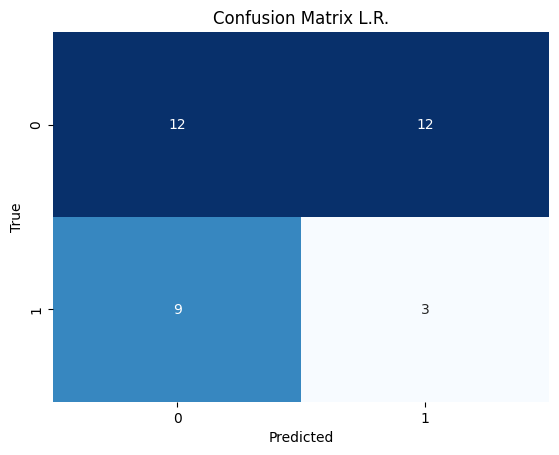

In [11]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix L.R.")

In [12]:
metrics = get_kfold_results(
    model=LogisticRegression(
        solver="liblinear", max_iter=1000, random_state=42, **best_params
    ),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
)

display_kfold_scores(metrics)

K-Fold Results
Accuracy: 52.86 ± 8.86
Precision: 33.00 ± 10.44
Recall: 45.56 ± 22.49
Specificity: 56.96 ± 3.70
F1 Score: 37.91 ± 14.84
Geometric Mean: 49.52 ± 13.15


In [ ]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="f1"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE
)
model = LogisticRegression(
    solver="liblinear", max_iter=1000, random_state=42, **best_params
)
model.fit(X_train_, y_train_)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

Best fold: 1
Accuracy: 64.29
Precision: 46.67
Recall: 77.78
Specificity: 57.89
F1 Score: 58.33
Geometric Mean: 67.10


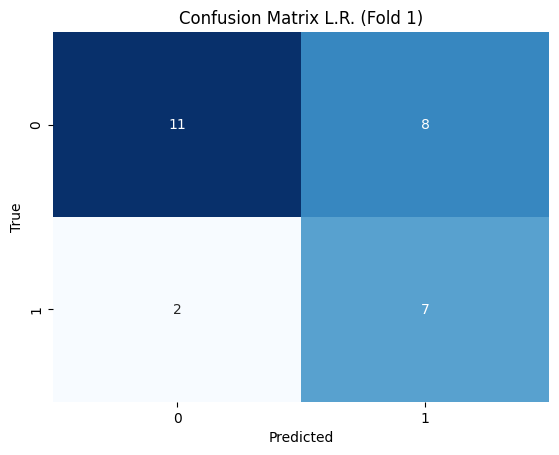

In [14]:
plot_confusion_matrix(
    y_test_, y_pred, title=f"Confusion Matrix L.R. (Fold {idx_best_fold + 1})"
)

## SVC


In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("select", SELECTOR),
        ("clf", SVC(random_state=42)),
    ]
)

param_grid = {
    'select__k': [10, 20, 30, 40, X.shape[-1]],
    'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__gamma': ['scale', 'auto'],
    'clf__class_weight': [None, 'balanced']
}

params = apply_grid_search(
    X_train, y_train, estimator=pipeline, param_grid=param_grid, scoring="f1"
)

best_params, best_k = extract_params_and_k(params, MODEL_PREFIX, K_KEY)

print(f"Best params: {best_params}")
print(f"Best k: {best_k}")

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best score: 0.5361179698897692
Best params: {'C': 100, 'class_weight': None, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best k: 42


In [16]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE
)


model = SVC(random_state=42, **best_params)


model.fit(X_train_, y_train)


y_pred = model.predict(X_test_)


_ = calculate_metrics(y_test, y_pred, display=True)

Accuracy: 52.78
Precision: 22.22
Recall: 16.67
Specificity: 70.83
F1 Score: 19.05
Geometric Mean: 34.36


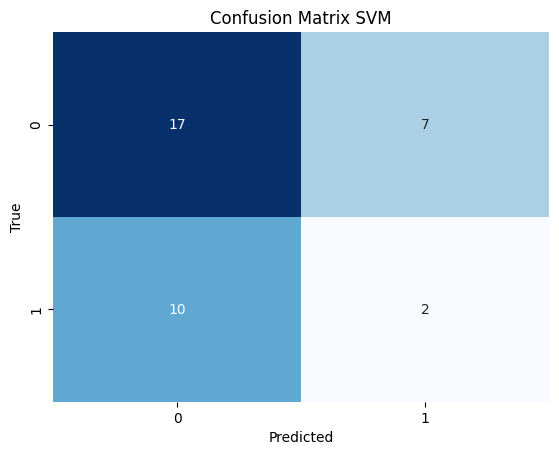

In [17]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix SVM")

In [18]:
metrics = get_kfold_results(
    model=SVC(random_state=42, **best_params),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
)

display_kfold_scores(metrics)

K-Fold Results
Accuracy: 60.00 ± 9.69
Precision: 42.82 ± 8.83
Recall: 42.67 ± 7.36
Specificity: 68.48 ± 13.36
F1 Score: 42.17 ± 6.73
Geometric Mean: 53.61 ± 7.22


In [ ]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="f1"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE
)
model = SVC(random_state=42, **best_params)
model.fit(X_train_, y_train_)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

Best fold: 3
Accuracy: 67.86
Precision: 50.00
Recall: 55.56
Specificity: 73.68
F1 Score: 52.63
Geometric Mean: 63.98


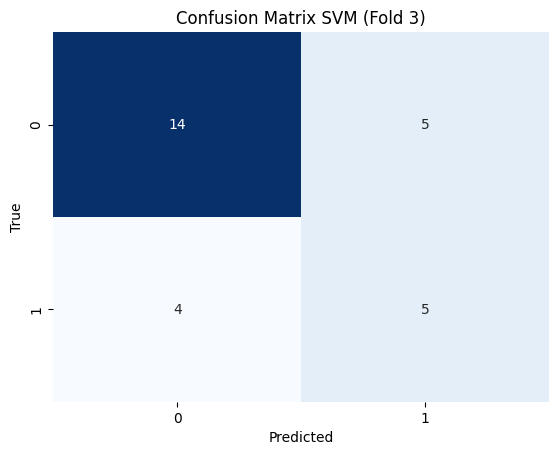

In [20]:
plot_confusion_matrix(
    y_test_, y_pred, title=f"Confusion Matrix SVM (Fold {idx_best_fold + 1})"
)

## KNN


In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("select", SELECTOR),
        ("clf", KNeighborsClassifier()),
    ]
)

param_grid = {
    'select__k': [10, 20, 30, 40, X.shape[-1]],
    'clf__n_neighbors': [3, 5, 7, 9, 11, 13],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2, 3],
}

params = apply_grid_search(
    X_train, y_train, estimator=pipeline, param_grid=param_grid, scoring="f1"
)

best_params, best_k = extract_params_and_k(params, MODEL_PREFIX, K_KEY)

print(f"Best params: {best_params}")
print(f"Best k: {best_k}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best score: 0.46195550022436593
Best params: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best k: 10


In [22]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE
)


model = KNeighborsClassifier(**best_params)

model.fit(X_train_, y_train)


y_pred = model.predict(X_test_)

_ = calculate_metrics(y_test, y_pred, display=True)

Accuracy: 55.56
Precision: 30.00
Recall: 25.00
Specificity: 70.83
F1 Score: 27.27
Geometric Mean: 42.08


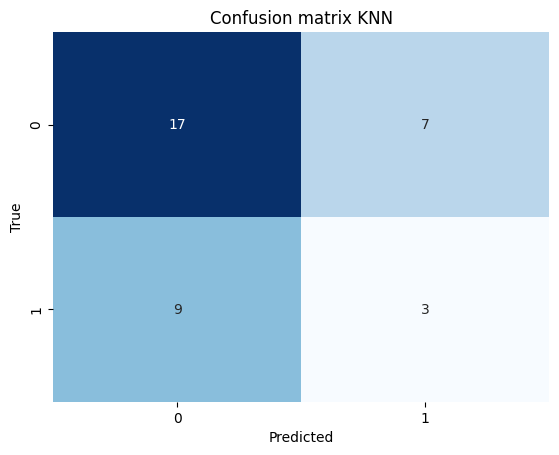

In [23]:
plot_confusion_matrix(y_test, y_pred, "Confusion matrix KNN")

In [24]:
metrics = get_kfold_results(
    model=KNeighborsClassifier(**best_params),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
)

display_kfold_scores(metrics)

K-Fold Results
Accuracy: 60.00 ± 6.93
Precision: 37.65 ± 13.64
Recall: 30.00 ± 12.49
Specificity: 75.32 ± 7.79
F1 Score: 32.83 ± 12.41
Geometric Mean: 46.20 ± 11.29


In [ ]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="f1"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE
)
model = KNeighborsClassifier(**best_params)
model.fit(X_train_, y_train_)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

Best fold: 4
Accuracy: 67.86
Precision: 57.14
Recall: 40.00
Specificity: 83.33
F1 Score: 47.06
Geometric Mean: 57.74


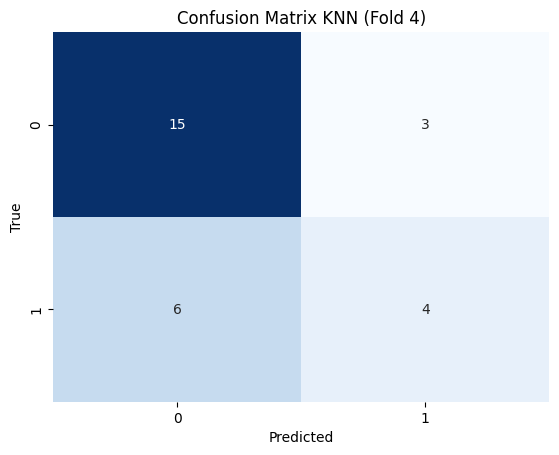

In [26]:
plot_confusion_matrix(
    y_test_, y_pred, title=f"Confusion Matrix KNN (Fold {idx_best_fold + 1})"
)